In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_1 = 'gait-dbase-1/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [3]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []

for subject in tqdm(subjects):
    files_path = os.path.join(path, subject)
    files = os.listdir(files_path)
    for filename in files:

        try:
            content = c3d(os.path.join(path, subject, filename), extract_forceplat_data=True)
            trajectory_x_l = content['data']['points'][1, 9:15, :]
            trajectory_y_l = content['data']['points'][1, 9:15, :]
            trajectory_z_l = content['data']['points'][2, 9:15, :]

            trajectory_x_r = content['data']['points'][1, 20:26, :]
            trajectory_y_r = content['data']['points'][1, 20:26, :]
            trajectory_z_r = content['data']['points'][2, 20:26, :]

            trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
            trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
            trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

            trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
            trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
            trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

            force_x_1 = content['data']['platform'][0]['force'][0, :]
            force_y_1 = content['data']['platform'][0]['force'][1, :]
            force_z_1 = content['data']['platform'][0]['force'][2, :]

            force_x_2 = content['data']['platform'][1]['force'][0, :]
            force_y_2 = content['data']['platform'][1]['force'][1, :]
            force_z_2 = content['data']['platform'][1]['force'][2, :]

            force_x_1 = resample(force_x_1, N_SAMPLES, axis=0).T
            force_y_1 = resample(force_y_1, N_SAMPLES, axis=0).T
            force_z_1 = resample(force_z_1, N_SAMPLES, axis=0).T

            force_x_2 = resample(force_x_2, N_SAMPLES, axis=0).T
            force_y_2 = resample(force_y_2, N_SAMPLES, axis=0).T
            force_z_2 = resample(force_z_2, N_SAMPLES, axis=0).T

            # force_combined_z = force_z_1 + force_z_2
            # force_mask = (force_combined_z >= FORCE_THRESHOLD)

            # trajectory_x_l = trajectory_x_l[force_mask, :]
            # trajectory_y_l = trajectory_y_l[force_mask, :]
            # trajectory_z_l = trajectory_z_l[force_mask, :]

            # trajectory_x_r = trajectory_x_r[force_mask, :]
            # trajectory_y_r = trajectory_y_r[force_mask, :]
            # trajectory_z_r = trajectory_z_r[force_mask, :]

            # trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
            # trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
            # trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

            # trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
            # trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
            # trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)

            # force_x_1 = force_x_1[force_mask]
            # force_y_1 = force_y_1[force_mask]
            # force_z_1 = force_z_1[force_mask]

            # force_x_2 = force_x_2[force_mask]
            # force_y_2 = force_y_2[force_mask]
            # force_z_2 = force_z_2[force_mask]

            # force_x_1 = resample(force_x_1, N_SAMPLES, axis=0)
            # force_y_1 = resample(force_y_1, N_SAMPLES, axis=0)
            # force_z_1 = resample(force_z_1, N_SAMPLES, axis=0)

            # force_x_2 = resample(force_x_2, N_SAMPLES, axis=0)
            # force_y_2 = resample(force_y_2, N_SAMPLES, axis=0)
            # force_z_2 = resample(force_z_2, N_SAMPLES, axis=0)

            force_x_l = 0
            force_y_l = 0
            force_z_l = 0
            force_x_r = 0
            force_y_r = 0
            force_z_r = 0

            fm1_z_l = trajectory_z_l[:, 3]
            peak_height = np.max(fm1_z_l)
            force_mask_1 = (force_z_1 >= FORCE_THRESHOLD)
            area_of_interest = fm1_z_l[force_mask_1]

            if peak_height in area_of_interest:
                force_x_l = force_x_2
                force_x_r = force_x_1
                force_y_l = force_y_2
                force_y_r = force_y_1
                force_z_l = force_z_2
                force_z_r = force_z_1

            else:
                force_x_l = force_x_1
                force_x_r = force_x_2
                force_y_l = force_y_1
                force_y_r = force_y_2
                force_z_l = force_z_1
                force_z_r = force_z_2
            
            
            _features_l = pd.DataFrame(
                np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features_r = pd.DataFrame(
                np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                columns=[
                    'fal_x', 'tam_x', 'fcc_x', 'fm1_x', 'fm2_x', 'fm5_x',
                    'fal_y', 'tam_y', 'fcc_y', 'fm1_y', 'fm2_y', 'fm5_y',
                    'fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z'
                ]
            )

            _features = pd.concat([_features_l, _features_r], axis=0)

            _target_r = pd.DataFrame(
                np.stack([force_x_r, force_y_r, force_z_r], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target_l = pd.DataFrame(
                np.stack([force_x_l, force_y_l, force_z_l], axis=1),
                columns=['fx', 'fy', 'fz']
            )

            _target = pd.concat([_target_r, _target_l], axis=0)

            features = pd.concat([features, _features], axis=0, ignore_index=True)
            target = pd.concat([target, _target], axis=0, ignore_index=True)

            records.append(filename)

        except Exception as e:
            # print('Error occured', e)
            pass



100%|██████████| 50/50 [04:14<00:00,  5.09s/it]


In [4]:
features

,fal_x,tam_x,fcc_x,fm1_x,fm2_x,fm5_x,fal_y,tam_y,fcc_y,fm1_y,fm2_y,fm5_y,fal_z,tam_z,fcc_z,fm1_z,fm2_z,fm5_z
0,315.077850,229.390457,266.381287,249.976181,307.238617,358.050293,315.077850,229.390457,266.381287,249.976181,307.238617,358.050293,75.325401,92.450508,39.130699,22.079981,35.831905,21.600080
1,312.579152,226.591457,264.572781,247.903697,305.345070,357.181279,312.579152,226.591457,264.572781,247.903697,305.345070,357.181279,76.706277,92.092801,41.526899,17.051512,31.799598,19.159787
2,311.619596,225.518568,263.876385,247.135499,304.630233,356.808721,311.619596,225.518568,263.876385,247.135499,304.630233,356.808721,77.493047,92.190563,42.817798,15.211522,30.329800,18.300263
3,311.968866,225.912648,264.126853,247.473506,304.915576,356.859162,311.968866,225.912648,264.126853,247.473506,304.915576,356.859162,77.765488,92.664582,43.162852,16.052687,31.010942,18.761375
4,313.162473,227.252454,264.989597,248.522765,305.844398,357.182654,313.162473,227.252454,264.989597,248.522765,305.844398,357.182654,77.704683,93.378374,42.899788,18.604518,33.062358,20.060689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340859,588.776160,499.829315,537.771668,494.301604,552.307457,607.668569,588.776160,499.829315,537.771668,494.301604,552.307457,607.668569,88.951285,107.897612,60.441223,27.226602,38.679747,15.017645
2340860,590.208334,501.228565,538.860786,493.641011,551.975643,608.574601,590.208334,501.228565,538.860786,493.641011,551.975643,608.574601,91.701780,107.875328,67.085564,17.569491,29.421408,8.038381
2340861,590.903281,501.937520,539.445906,493.344236,551.811358,608.987513,590.903281,501.937520,539.445906,493.344236,551.811358,608.987513,93.257236,108.032098,70.473741,13.150047,25.191826,4.858833
2340862,588.543256,499.772252,537.912991,494.501770,552.295708,607.346484,588.543256,499.772252,537.912991,494.501770,552.295708,607.346484,89.710778,108.763776,60.300532,30.066707,41.445886,17.137356


In [5]:
target

,fx,fy,fz
0,-0.009782,-0.000873,-0.003389
1,0.009764,0.000868,0.003281
2,-0.009745,-0.000862,-0.003172
3,0.009727,0.000857,0.003064
4,-0.009709,-0.000851,-0.002956
...,...,...,...
2340859,-0.000648,-0.000282,0.026254
2340860,0.000655,0.000286,-0.026192
2340861,-0.000662,-0.000290,0.026132
2340862,0.000669,0.000294,-0.026072


In [6]:
path = '../../Dataset/Processed/data.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data.joblib']

In [7]:
features_z = features[['fal_z', 'tam_z', 'fcc_z', 'fm1_z', 'fm2_z', 'fm5_z']].to_numpy()
target_z = target[['fz']].to_numpy()

In [8]:
X = features_z.reshape(-1, 1024, 6)
y = target_z.reshape(-1, 1024, 1)

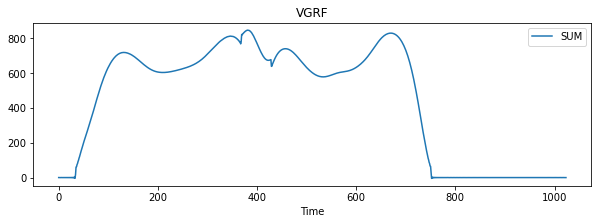

In [60]:
sample = 1116

plt.figure(figsize=(10, 3))
# plt.plot(X[sample, :, 1])
y1 = y[1110, :, 0].T
y2 = y[1111, :, 0].T
plt.plot(y1 + y2)
# plt.plot(y2)
plt.title('VGRF')
plt.xlabel('Time')
plt.legend(['SUM'])
plt.show()

In [10]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_1)
files_path = os.path.join(path, subjects[0])
file_path = os.path.join(files_path, records[1])

In [11]:
content = c3d(file_path, extract_forceplat_data=True)

trajectory_x_l = content['data']['points'][1, 9:15, :]
trajectory_y_l = content['data']['points'][1, 9:15, :]
trajectory_z_l = content['data']['points'][2, 9:15, :]

trajectory_x_r = content['data']['points'][1, 20:26, :]
trajectory_y_r = content['data']['points'][1, 20:26, :]
trajectory_z_r = content['data']['points'][2, 20:26, :]

trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

force_x_1 = content['data']['platform'][0]['force'][0, :]
force_y_1 = content['data']['platform'][0]['force'][1, :]
force_z_1 = content['data']['platform'][0]['force'][2, :]

force_x_2 = content['data']['platform'][1]['force'][0, :]
force_y_2 = content['data']['platform'][1]['force'][1, :]
force_z_2 = content['data']['platform'][1]['force'][2, :]

force_x_1 = resample(force_x_1, N_SAMPLES, axis=0).T
force_y_1 = resample(force_y_1, N_SAMPLES, axis=0).T
force_z_1 = resample(force_z_1, N_SAMPLES, axis=0).T

force_x_2 = resample(force_x_2, N_SAMPLES, axis=0).T
force_y_2 = resample(force_y_2, N_SAMPLES, axis=0).T
force_z_2 = resample(force_z_2, N_SAMPLES, axis=0).T

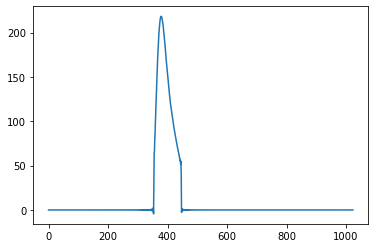

In [12]:
plt.plot((force_z_2))